In [2]:
import h5py
import os
import glob
import re


In [3]:
%load_ext autoreload
%autoreload 
import sys


In [4]:
import sys
sys.path.append('./code/')

from initialize import *
from hic_zscore_functions import *

In [5]:
CHROMS_TO_USE = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', 'X']

In [6]:
%autoreload 2
import initialize
from initialize import *

In [7]:
### Files can be found on GEO; not included in LFS

treg_rep1 = cooler.Cooler('./coolfiles/Treg_rep1_MAPQ30_raw_50000.cool')
treg_rep2 = cooler.Cooler('./coolfiles/Treg_rep2_MAPQ30_raw_50000.cool')
treg_rep3 = cooler.Cooler('./coolfiles/Treg_rep3_MAPQ30_raw_50000.cool')

tcon_rep1 = cooler.Cooler('./coolfiles/Tn_rep1_MAPQ30_raw_50000.cool')
tcon_rep2 = cooler.Cooler('./coolfiles/Tn_rep2_MAPQ30_raw_50000.cool')
tcon_rep3 = cooler.Cooler('./coolfiles/Tn_rep3_MAPQ30_raw_50000.cool')


In [8]:
%autoreload 2
import initialize
from initialize import *

chrom = '2'
treg_cool = cooler.Cooler("./Treg_all.mcool::/resolutions/50000")
tcon_cool = cooler.Cooler("./Tconv_all.mcool::/resolutions/50000")

cooldict = {
'treg' : treg_cool,
'tcon' : tcon_cool,
}

(_, _, region_to_inds_50kb, 
    all_region_to_ind_50kb, inds_to_region_50kb, all_ind_to_region_50kb,
    chrom_to_start_50kb, chrom_to_end_50kb) = initialize_helper_vars(tcon_cool)

gene_to_ind_50kb, ind_to_gene_50kb = initialize_genes(all_ind_to_region_50kb, all_region_to_ind_50kb)

In [9]:
from plotting_functions import *

In [10]:
from call_compartments import *

cooldict = {
'treg' : treg_cool,
'tcon' : tcon_cool,
}

comp_dict = calculate_my_pcs(cooldict, all_ind_to_region_50kb, inds_to_region_50kb, chrom_to_start_50kb, chrom_to_end_50kb)
my_treg_comp, my_tcon_comp = comp_dict['treg'], comp_dict['tcon']

/Genomics/pritykinlab/gabe/jupys/tregs/./code/call_compartments.py:90: RuntimeWarning: Mean of empty slice
  v = np.nanmean(np.diag(m, k=i))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/call_compartments.py:135: RuntimeWarning: invalid value encountered in divide
  oe = np.log2((a)/(a_exp))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/call_compartments.py:135: RuntimeWarning: divide by zero encountered in log2
  oe = np.log2((a)/(a_exp))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/call_compartments.py:136: RuntimeWarning: invalid value encountered in divide
  oe_with_pc = np.log2((a+2*pc)/(a_exp+2*pc))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/call_compartments.py:90: RuntimeWarning: Mean of empty slice
  v = np.nanmean(np.diag(m, k=i))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/call_compartments.py:135: RuntimeWarning: invalid value encountered in divide
  oe = np.log2((a)/(a_exp))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/call_compartments.py:135: RuntimeWarning: divid

In [11]:
def make_inputs(cool, label):
    inps = []
    for chrom in CHROMS_TO_USE:
        inps.append([cool, chrom, chrom, label])
    return inps
    
def run(inp, silent=True):
    cool, chrom, chrom, label = inp
    bal_intra, raw_intra, oe = prepare_inputs(cool, chrom, chrom)
    peak_smooth_X1, peak_smooth_Y1, z = compute_prominent_peaks(oe)
    full_logp_mat = get_hiccups_pvalue(raw_intra, bal_intra)
    collapsed_logp_mat = collapse_hiccups_and_peak_pvalues(full_logp_mat, peak_smooth_X1, peak_smooth_Y1, oe)    
    
    pref = 'metadomain_prominent_peak_output/'
    np.save(pref + f'{label}_chrL={chrom}_chrR={chrom}_peak_smooth_X1', peak_smooth_X1)
    np.save(pref + f'{label}_chrL={chrom}_chrR={chrom}_peak_smooth_Y1', peak_smooth_Y1)
    np.save(pref + f'{label}_chrL={chrom}_chrR={chrom}_full_logp_mat', full_logp_mat)
    np.save(pref + f'{label}_chrL={chrom}_chrR={chrom}_collapsed_logp_mat', collapsed_logp_mat)
    np.save(pref + f'{label}_chrL={chrom}_chrR={chrom}_bal_intra', bal_intra)
    np.save(pref + f'{label}_chrL={chrom}_chrR={chrom}_raw_intra', raw_intra)
    np.save(pref + f'{label}_chrL={chrom}_chrR={chrom}_oe', oe)
    if silent==True:
        return None
    else:
        return bal_intra, raw_intra, oe, peak_smooth_X1, peak_smooth_Y1, full_logp_mat, collapsed_logp_mat
    

### Identify intrachromosomal metadomains

In [12]:
%autoreload
from concurrent.futures import ProcessPoolExecutor
from get_focal_contacts_with_peak_prominence import *

treg_inps = make_inputs(treg_cool, label='treg_res=50000_intrachromosomal')
tcon_inps = make_inputs(tcon_cool, label='tcon_res=50000_intrachromosomal')
all_inps = treg_inps + tcon_inps
n_workers = 80

with ProcessPoolExecutor(max_workers=n_workers) as e:
    treg_results = e.map(run, all_inps, chunksize=1)

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/

For replicates separately

In [13]:
%autoreload
from concurrent.futures import ProcessPoolExecutor
from get_focal_contacts_with_peak_prominence import *

treg_rep1_inps = make_inputs(treg_rep1, label='treg_rep1_res=50000_intrachromosomal')
treg_rep2_inps = make_inputs(treg_rep2, label='treg_rep2_res=50000_intrachromosomal')
treg_rep3_inps = make_inputs(treg_rep3, label='treg_rep3_res=50000_intrachromosomal')

all_inps = treg_rep1_inps + treg_rep2_inps + treg_rep3_inps

n_workers = 16

with ProcessPoolExecutor(max_workers=n_workers) as e:
    treg_results = e.map(run, all_inps, chunksize=1)

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/

In [14]:
%autoreload
from concurrent.futures import ProcessPoolExecutor
from get_focal_contacts_with_peak_prominence import *

tcon_rep1_inps = make_inputs(tcon_rep1, label='tcon_rep1_res=50000_intrachromosomal')
tcon_rep2_inps = make_inputs(tcon_rep2, label='tcon_rep2_res=50000_intrachromosomal')
tcon_rep3_inps = make_inputs(tcon_rep3, label='tcon_rep3_res=50000_intrachromosomal')

all_inps = tcon_rep1_inps + tcon_rep2_inps + tcon_rep3_inps

n_workers = 16

with ProcessPoolExecutor(max_workers=n_workers) as e:
    tcon_results = e.map(run, all_inps, chunksize=1)

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/

#### Supplemental QC plots

In [15]:
bincounts = []
bincount_dict = {}
pref = './metadomain_prominent_peak_output'
for chrom in CHROMS_TO_USE:
    l = np.load(f'{pref}/treg_res=50000_intrachromosomal_chrL={chrom}_chrR={chrom}_collapsed_logp_mat.npy')
    l = np.triu(l, k = 40)
    l += l.T
    n_metadomains = (l>0).sum(axis=0)
    bincounts += list(n_metadomains)
    bincount_dict[chrom] = n_metadomains
bincounts = arr(bincounts)

In [16]:
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

#### # metadomains per bin

(-0.5, 10.0)

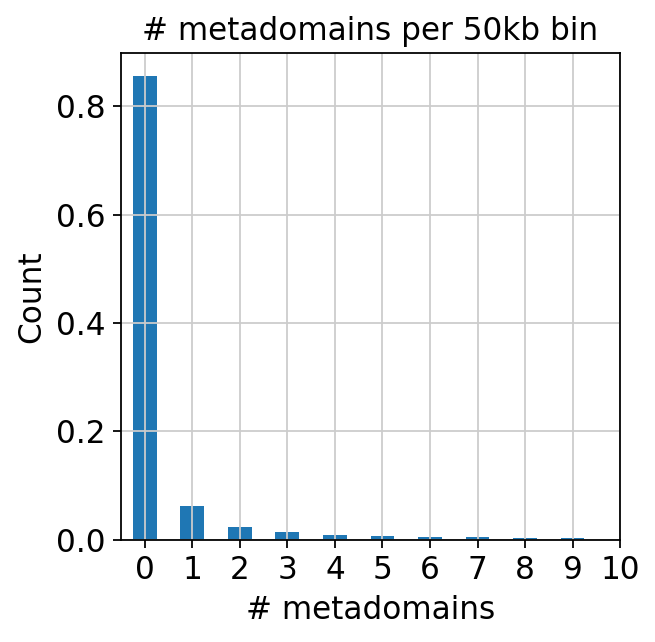

In [22]:
frac_with_metadomain = (bincounts > 0).mean().round(2)
plt.figure(figsize=(4, 4))
metadomain_count_df = pd.Series(bincounts).value_counts().sort_index()
metadomain_count_df = metadomain_count_df / metadomain_count_df.sum()
metadomain_count_df.plot.bar()
plt.xticks(rotation=0)
plt.xlabel("# metadomains")
plt.ylabel("Count")
plt.title("# metadomains per 50kb bin")
plt.xlim([-.5, 10])

#### # metadomains vs. Chrom Length

Text(0.5, 0, 'Chromosome Length (Mb)')

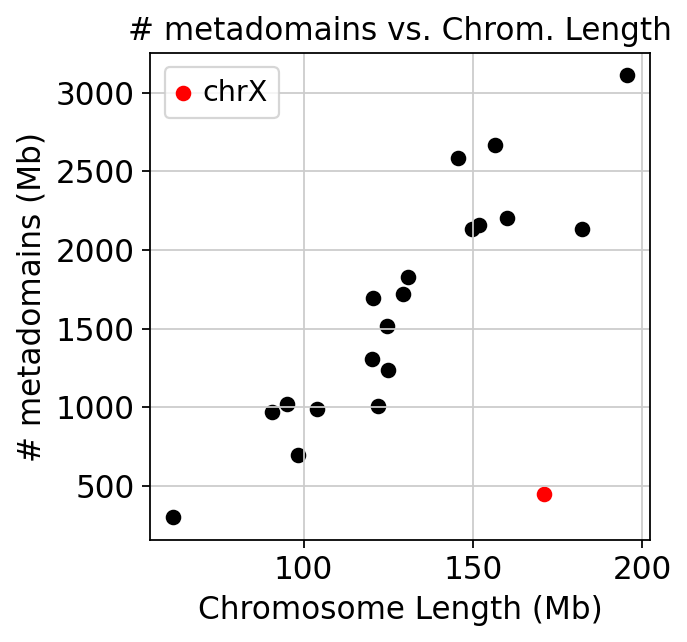

In [19]:
res = 50_000
for chrom in CHROMS_TO_USE:
    y = arr(bincount_dict[chrom]).sum()
    x = (chrom_to_end_50kb[chrom]-chrom_to_start_50kb[chrom])*res/1e6
    if chrom == 'X':
        plt.scatter(x, y, color='red', label='chrX')
    else:
        plt.scatter(x, y, color='black')        
plt.legend()
plt.title("# metadomains vs. Chrom. Length")
plt.ylabel("# metadomains (Mb)")
plt.xlabel("Chromosome Length (Mb)")

#### # metadomains vs Compartment

In [23]:
# for chrom in CHROMS_TO_USE:
#     s, e = chrom_to_start_50kb[chrom], chrom_to_end_50kb[chrom]
#     comps = my_treg_comp[s:e]
#     n_metadomains = bincount_dict[chrom4]
#     assert len(comps) == len(n_metadomains)
#     df = pd.DataFrame()
#     df['# metadomains'] = n_metadomains
#     df['Comp Score'] = comps
#     df = df.groupby(['# metadomains']).mean().reset_index()
#     x, y = df['# metadomains'], df['Comp Score']
#     if chrom == 'X':
#         plt.plot(x, y, color='black', alpha=.2)
#     else:
#         plt.plot(x, y, color='black', alpha=.2)
#     plt.xlim([-1, 40])
#     plt.ylabel("Compartment score")
#     plt.xlabel("# metadomains")
#     plt.ylim([-2, 2])
#     plt.title("# metadomains vs Comp. Score")

# Identify interchromosomal metadomains

In [24]:
def make_inputs_inter(cool, label, CHROMS_TO_USE=CHROMS_TO_USE):
    inps = []
    for chrom1 in CHROMS_TO_USE:
        for chrom2 in CHROMS_TO_USE:
            if chrom1 == chrom2:
                continue
            inps.append([cool, chrom1, chrom2, label])
    return inps
    
def run_inter(inp, silent=True):
    cool, chrom1, chrom2, label = inp
    bal_intra, raw_intra, oe = prepare_inputs(cool, chrom1, chrom2, type='inter')
    peak_smooth_X1, peak_smooth_Y1, z = compute_prominent_peaks(oe, useSigma=True, sigma=2)
    full_logp_mat = get_hiccups_pvalue(raw_intra, bal_intra, type='inter', filter_n=15, filter_width=3,)
    collapsed_logp_mat = collapse_hiccups_and_peak_pvalues(full_logp_mat, peak_smooth_X1, 
                                                           peak_smooth_Y1, oe, pco=5) 
    collapsed_logp_mat[oe < 6] = 0
    
    pref = 'metadomain_prominent_peak_output_try2/'
    np.save(pref + f'{label}_chrL={chrom1}_chrR={chrom2}_peak_smooth_X1', peak_smooth_X1)
    np.save(pref + f'{label}_chrL={chrom1}_chrR={chrom2}_peak_smooth_Y1', peak_smooth_Y1)
    np.save(pref + f'{label}_chrL={chrom1}_chrR={chrom2}_full_logp_mat', full_logp_mat)
    np.save(pref + f'{label}_chrL={chrom1}_chrR={chrom2}_collapsed_logp_mat', collapsed_logp_mat)
    np.save(pref + f'{label}_chrL={chrom1}_chrR={chrom2}_bal_intra', bal_intra)
    np.save(pref + f'{label}_chrL={chrom1}_chrR={chrom2}_raw_intra', raw_intra)
    np.save(pref + f'{label}_chrL={chrom1}_chrR={chrom2}_oe', oe)
    sparse_collapsed_logp_mat = scipy.sparse.csr_matrix(collapsed_logp_mat)
    scipy.sparse.save_npz(pref + f'{label}_chrL={chrom1}_chrR={chrom2}_collapsed_logp_mat_sparse', sparse_collapsed_logp_mat)
    if silent==True:
        return None
    else:
        return bal_intra, raw_intra, oe, peak_smooth_X1, peak_smooth_Y1, full_logp_mat, collapsed_logp_mat
    

In [25]:
from concurrent.futures import ProcessPoolExecutor
from get_focal_contacts_with_peak_prominence import *

treg_inps_inter = make_inputs_inter(treg_cool, label='treg_res=50000_interchromosomal', CHROMS_TO_USE=CHROMS_TO_USE)
tcon_inps_inter = make_inputs_inter(tcon_cool, label='tcon_res=50000_interchromosomal', CHROMS_TO_USE=CHROMS_TO_USE)
all_inps_inter = treg_inps_inter + tcon_inps_inter
n_workers = 15

with ProcessPoolExecutor(max_workers=n_workers) as e:
    treg_results = e.map(run_inter, all_inps_inter, chunksize=1)